In [1]:
import pandas as pd
import pysam
import numpy as np
import akita_utils
import seaborn as sns
import bioframe as bf

In [2]:
from akita_utils.dna_utils import scan_motif, dna_1hot
from akita_utils.format_io import read_jaspar_to_numpy

2023-10-03 14:14:48.095194: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home1/smaruj/software/GSL/lib:/home1/smaruj/software/HTSLIB/lib
2023-10-03 14:14:48.095263: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# from akita_utils.format_io import read_rmsk
# from akita_utils.tsv_gen_utils import filter_by_overlap_num

from io import StringIO

def read_rmsk(rmsk_file="/project/fudenber_735/genomes/mm10/database/rmsk.txt.gz"):
    
    """reads a data frame containing repeatable elements and renames columns specifying genomic intervals to standard: chrom, start, end, used in thie repo."""
    
    rmsk_cols = list(
        pd.read_csv(
            StringIO(
                """bin swScore milliDiv milliDel milliIns genoName genoStart genoEnd genoLeft strand repName repClass repFamily repStart repEnd repLeft id"""
            ),
            sep=" ",
        )
    )

    rmsk = pd.read_table(
        rmsk_file,
        names=rmsk_cols,
    )
    
    rmsk.rename(
        columns={"genoName": "chrom", "genoStart": "start", "genoEnd": "end"},
        inplace=True,
    )
    
    return rmsk

def filter_by_overlap_num(
    working_df,
    filter_df,
    expand_window=60,
    working_df_cols=["chrom","start","end"],
    filter_df_cols=["chrom","start","end"],
    max_overlap_num=0):
    
    """
    Filter out rows from working_df that overlap entries in filter_df above given threshold.

    Parameters
    -----------
    working_df : dataFrame
        First set of genomic intervals.
    filter_df : dataFrame
        Second set of genomic intervals.
    expand_window : int
        Indicates how big window around the given genomic intervals should be taken into account.
    working_df_cols : list
        Columns specifying genomic intervals in the working_df.
    filter_df_cols : list
        Columns specifying genomic intervals in the filter_df.
    max_overlap_num : int
        All the rows with number of overlaps above this threshold will be filtered out.
        
    Returns
    --------
    working_df : dataFrame
        Subset of working_df that do not have overlaps with filter_df above given threshold.

    """
    
    filter_df = bf.expand(filter_df, pad=expand_window)
    
    working_df = bf.count_overlaps(working_df, filter_df[filter_df_cols], cols1=working_df_cols)
    
    working_df = working_df.iloc[working_df["count"].values <= max_overlap_num]
    working_df.reset_index(inplace=True, drop=True)

    return working_df

# reading tsv with all mouse ctcf motifs (that overlap boundaries)

In [4]:
all_ctcf_path = "/project/fudenber_735/tensorflow_models/akita/v2/analysis/to_insert_boundaries.motifs.ctcf.mm10.tsv"
df = pd.read_csv(all_ctcf_path, sep="\t")

### Since the set of motifs is the same for all backgrounds, we can focus on a subset of the table corresponding to one background (e.g. the 0th background)

In [5]:
df = df[df["background_index"] == 0]

# removing some not necessary columns from the table for clarity
columns_to_keep = ["boundary_index", "chrom", "boundary_end", "index", "num_ctcf", "span", "boundary_start", "strand", "start", "end"]
df = df[columns_to_keep]

In [6]:
df

,boundary_index,chrom,boundary_end,index,num_ctcf,span,boundary_start,strand,start,end
0,0,chr1,4410000,0,2,4403267-4403286,4400000,-,4403267,4403286
1,0,chr1,4410000,1,2,4405891-4405910,4400000,+,4405891,4405910
2,1,chr1,4780000,4,10,4770055-4770074,4770000,+,4770055,4770074
3,1,chr1,4780000,5,10,4770180-4770199,4770000,-,4770180,4770199
4,1,chr1,4780000,6,10,4770867-4770886,4770000,+,4770867,4770886
...,...,...,...,...,...,...,...,...,...,...
18136,4472,chr19,59390000,26377,10,59388676-59388695,59380000,-,59388676,59388695
18137,4472,chr19,59390000,26378,10,59389390-59389409,59380000,+,59389390,59389409
18138,4473,chr19,59780000,26381,3,59770157-59770176,59770000,-,59770157,59770176
18139,4473,chr19,59780000,26382,3,59770474-59770493,59770000,+,59770474,59770493


# filtering

## 1. by ctcf

In [7]:
# jaspar tsv
jaspar_file = "/project/fudenber_735/motifs/mm10/jaspar/MA0139.1.tsv.gz"
jaspar_df = bf.read_table(jaspar_file, schema="jaspar")

# filtering
filtered_df = filter_by_overlap_num(df,
                    filter_df=jaspar_df,
                     max_overlap_num=1)

In [8]:
len(df) - len(filtered_df)

2351

In [9]:
# 2351 sites have been excluded from the analysis since they overlap another ctcf sites

## 2. by rmsk (a table with repeatable elements e.g. SINE, LINE, ect.)

In [10]:
rmsk_file = "/project/fudenber_735/genomes/mm10/database/rmsk.txt.gz"
rmsk_df = read_rmsk(rmsk_file)

In [11]:
filtered_df = filter_by_overlap_num(filtered_df,
                        rmsk_df,
                        expand_window=20,
                        working_df_cols = ["chrom","start","end"])

In [12]:
len(filtered_df)

7560

In [ ]:
# More than half of the sites have been filtered out. It's okay since we prefer to work with smaller, but high-quality sites (meaning that the effect of their insertion  disruption is not affected by overlapping ctct sites or repeatable genomic elements)

# ctcf motifs scanning

In [ ]:
# Sites' strand annotation is based on original sites' annotation from the jaspar database.
# Since we want to study potentially orientation-dependent phenomenon, let's double check that our (local) method that scans ctcf gives the same strand as jaspar's method.

In [13]:
genome_file = "/project/fudenber_735/genomes/mm10/mm10.fa"

# reading CTCF motif from the jaspar file
motif_matrix = read_jaspar_to_numpy()

In [14]:
def get_forward_score(s, flank_bp=20):
    
    motif_matrix = read_jaspar_to_numpy()
    dna = dna_1hot(genome_open.fetch(s.chrom, s.start - flank_bp, s.end + flank_bp).upper())
    
    max_forward_score = scan_motif(dna, motif_matrix, strand="forward").max()
    
    return max_forward_score


def get_reverse_score(s, flank_bp=20):
    
    motif_matrix = read_jaspar_to_numpy()
    dna = dna_1hot(genome_open.fetch(s.chrom, s.start - flank_bp, s.end + flank_bp).upper())
    
    max_reverse_score = scan_motif(dna, motif_matrix, strand="reverse").max()
    
    return max_reverse_score


def get_scan_strand(s):
    
    if s.forward_scan >= s.reverse_scan:
        return "+"
    else:
        return "-"


def check_mismatch(s):
    if s.strand != s.scan_strand:
        return 1
    else:
        return 0


def get_rf_diff(s):
    diff = s.forward_scan - s.reverse_scan
    if diff >= 0:
        return diff
    else:
        return -1 * diff

In [17]:
genome_open = pysam.Fastafile(genome_file)

filtered_df.loc[:, ("forward_scan")] = filtered_df.apply(get_forward_score, axis=1)
filtered_df.loc[:, ("reverse_scan")] = filtered_df.apply(get_reverse_score, axis=1)
filtered_df.loc[:, ("scan_strand")] = filtered_df.apply(get_scan_strand, axis=1)
filtered_df.loc[:, ("mismatch")] = filtered_df.apply(check_mismatch, axis=1)
filtered_df.loc[:, ("rf_diff")] = filtered_df.apply(get_rf_diff, axis=1)

genome_open.close()

## Do we have any sites with mismatches?

In [19]:
mismatch_df = filtered_df[filtered_df["mismatch"] == 1]

In [20]:
len(mismatch_df)

54

In [21]:
# What are the absolute differences between forward and reverse scanning?

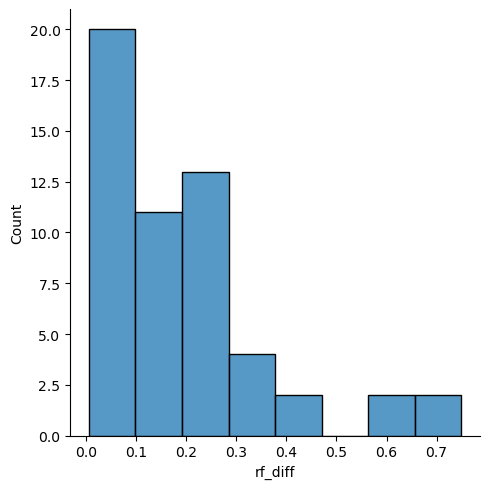

In [22]:
sns.displot(mismatch_df , x="rf_diff")

In [23]:
# The differences are relatively small.
# We need to also notice that:
#     - we scanned within bigger window (site + 20 bp flanks), then the maximum was returned
#     - jaspar's method is more complex, they use k-mer frequencies in the background to estimate probabilty of motif appearing by chance - our model simply multipy two matrices

In [24]:
# Let's check thus hypothesis by scanning without flanks

# No-flanks scanning

In [32]:
def get_forward_score_no_flanks(s):
    
    motif_matrix = read_jaspar_to_numpy()
    dna = dna_1hot(genome_open.fetch(s.chrom, s.start, s.end).upper())
    
    max_forward_score = scan_motif(dna, motif_matrix, strand="forward").max()
    
    return max_forward_score


def get_reverse_score_no_flanks(s):
    
    motif_matrix = read_jaspar_to_numpy()
    dna = dna_1hot(genome_open.fetch(s.chrom, s.start, s.end).upper())
    
    max_reverse_score = scan_motif(dna, motif_matrix, strand="reverse").max()
    
    return max_reverse_score

def get_scan_strand_no_flanks(s):
    
    if s.nf_forward >= s.nf_reverse:
        return "+"
    else:
        return "-"


In [30]:
genome_open = pysam.Fastafile(genome_file)

mismatch_df["nf_forward"] = mismatch_df.apply(get_forward_score_no_flanks, axis=1)
mismatch_df["nf_reverse"] = mismatch_df.apply(get_reverse_score_no_flanks, axis=1)
mismatch_df["nf_forward_reverse"] = mismatch_df["nf_forward"] - mismatch_df["nf_reverse"]

genome_open.close()

/tmp/SLURM_16707967/ipykernel_12118/307503780.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatch_df["nf_forward"] = mismatch_df.apply(get_forward_score_no_flanks, axis=1)
/tmp/SLURM_16707967/ipykernel_12118/307503780.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatch_df["nf_reverse"] = mismatch_df.apply(get_reverse_score_no_flanks, axis=1)
/tmp/SLURM_16707967/ipykernel_12118/307503780.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [33]:
mismatch_df["nf_strand_scan"] = mismatch_df.apply(get_scan_strand_no_flanks, axis=1)

/tmp/SLURM_16707967/ipykernel_12118/2870194531.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatch_df["nf_strand_scan"] = mismatch_df.apply(get_scan_strand_no_flanks, axis=1)


In [37]:
mismatch_df.columns

Index(['boundary_index', 'chrom', 'boundary_end', 'index', 'num_ctcf', 'span',
       'boundary_start', 'strand', 'start', 'end', 'count', 'count',
       'forward_scan', 'reverse_scan', 'scan_strand', 'mismatch', 'rf_diff',
       'nf_forward', 'nf_reverse', 'nf_forward_reverse', 'nf_strand_scan'],
      dtype='object')

In [38]:
# Do we have any mismatches?
mismatch_df[mismatch_df["nf_strand_scan"] != mismatch_df["strand"]]

,boundary_index,chrom,boundary_end,index,num_ctcf,span,boundary_start,strand,start,end,...,count,forward_scan,reverse_scan,scan_strand,mismatch,rf_diff,nf_forward,nf_reverse,nf_forward_reverse,nf_strand_scan
1025,663,chr2,154630000,3617,7,154624162-154624181,154620000,+,154624162,154624181,...,0,9.699041,10.097949,-,1,0.398908,9.699041,9.952575,-0.253533,-
2294,1456,chr5,112430000,8202,9,112422808-112422827,112420000,-,112422808,112422827,...,0,9.994862,9.409827,+,1,0.585035,9.493761,9.409827,0.083933,+
4182,2475,chr9,96890000,14546,10,96887023-96887042,96880000,-,96887023,96887042,...,0,9.583424,8.983223,+,1,0.600201,9.161618,8.983223,0.178395,+
4383,2605,chr10,41300000,15310,7,41291282-41291301,41290000,-,41291282,41291301,...,0,10.026636,9.277279,+,1,0.749357,9.503508,9.277279,0.226229,+
5659,3324,chr13,49760000,19672,3,49757470-49757489,49750000,+,49757470,49757489,...,0,9.509056,9.698011,-,1,0.188955,9.509056,9.552637,-0.043581,-


In [39]:
# Five sites have still mismatched strands, although the absolute differences between forward and reverse scanning results are very small.
# It seems that our hypothesis was correct, our scanning method has detected signal in flanking regions and reported the opposite strand.

In [40]:
# To be sure, let's repeat scanning using a third, independent method (fimo)

# tsv saving

In [46]:
# assuming that there is ctcf-like signal in the flanks of those sites that we have caught up by scanning within window including flanks, we should not incluse those 54 sites in our experiments
# Due to the fact, we're saving only "matched" sites and going to use them as our basic ctcf sites tsv table

no_mismatch_filtered_df = filtered_df[filtered_df["mismatch"] == 0]
no_mismatch_filtered_df.to_csv("./filtered_base_mouse_ctcf.tsv", sep = "\t", index=False)

In [47]:
# sites to be checked using fimo
mismatch_df.to_csv("./filtered_base_mouse_ctcf_mismatched.tsv", sep = "\t", index=False)

In [48]:
# sites have been saved as separated tsv files depending if they are ready to use (filtered_base_mouse_ctcf.tsv)
# or need to be scanned using fimo

In [56]:
mismatch_df.head()

,boundary_index,chrom,boundary_end,index,num_ctcf,span,boundary_start,strand,start,end,...,count,forward_scan,reverse_scan,scan_strand,mismatch,rf_diff,nf_forward,nf_reverse,nf_forward_reverse,nf_strand_scan
315,229,chr1,128370000,1178,4,128367145-128367164,128360000,+,128367145,128367164,...,0,9.578156,9.731974,-,1,0.153818,9.578156,9.230873,0.347284,+
408,288,chr1,160200000,1493,6,160197509-160197528,160190000,+,160197509,160197528,...,0,9.499476,9.555386,-,1,0.055910,9.499476,6.302327,3.197149,+
412,292,chr1,161740000,1513,5,161735161-161735180,161730000,-,161735161,161735180,...,0,9.410670,9.245034,+,1,0.165636,8.551640,9.245034,-0.693395,-
513,341,chr1,184800000,1832,6,184790806-184790825,184790000,+,184790806,184790825,...,0,9.374499,9.455610,-,1,0.081111,9.374499,8.901645,0.472854,+
550,363,chr2,3850000,1979,4,3840133-3840152,3840000,-,3840133,3840152,...,0,9.989558,9.828651,+,1,0.160907,9.661364,9.828651,-0.167287,-


# preparing FIMO input

In [ ]:
# Let's prepare two fasta files: one with, the other without flanks.

In [62]:
genome_open = pysam.Fastafile(genome_file)

# no flanks fasta file
with open("./filtered_base_mouse_ctcf_mismatched_no_flanks.fasta", "w") as no_flanks_fasta:
    for row in mismatch_df.itertuples():
        start = row.start
        end = row.end
        chrom = row.chrom
    
        identifier = f">chr:{chrom}_s:{start}_e:{end}"
            
        seq = genome_open.fetch(chrom, start, end)
        no_flanks_fasta.write(identifier)
        no_flanks_fasta.write("\n")
        no_flanks_fasta.write(seq)
        no_flanks_fasta.write("\n")

genome_open.close()

In [63]:
genome_open = pysam.Fastafile(genome_file)

# fasta file with flanks
flank = 20
with open("./filtered_base_mouse_ctcf_mismatched_with_flanks.fasta", "w") as flanks_fasta:
    for row in mismatch_df.itertuples():
        start = row.start
        end = row.end
        chrom = row.chrom
    
        identifier = f">chr:{chrom}_s:{start}_e:{end}"
            
        seq = genome_open.fetch(chrom, start-flank, end+flank)
        flanks_fasta.write(identifier)
        flanks_fasta.write("\n")
        flanks_fasta.write(seq)
        flanks_fasta.write("\n")

genome_open.close()